## Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [1]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import anthropic as ant
import google.generativeai as genai

In [23]:
load_dotenv(override=True)

try:
    from google.colab import userdata
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

API_KEYS = {
    "OpenAI": ("OPENAI_API_KEY", 8),
    "Anthropic": ("ANTHROPIC_API_KEY", 7),
    "Google": ("GOOGLE_API_KEY", 2)
}

keys = {}

for label, (env_name, _) in API_KEYS.items():
    if IN_COLAB:
        keys[label] = userdata.get(env_name)
    else:
        keys[label] = os.getenv(env_name)


def check_key(label, prefix_len):
    key = keys[label]
    if key:
        print(f"{label} API Key exists and begins {key[:prefix_len]}")
    else:
        print(f"{label} API Key not set (optional)")

for label, (_, prefix_len) in API_KEYS.items():
    check_key(label, prefix_len)


OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-
Google API Key exists and begins AI


In [3]:
openai  = OpenAI(api_key=keys["OpenAI"])
anthropic = ant.Anthropic(api_key=keys["Anthropic"])
genai.configure(api_key=keys["Google"])

In [4]:
max_tokens = 512
gpt_model = "gpt-4o-mini"
claude_model = "claude-3-haiku-20240307"
gemini_model = "models/gemini-2.0-flash"
system_prompt = """
You are a helpful assistant for an Airline called FlightAI.
Give short, courteous answers, no more than 1 sentence.
Always be accurate. If you don't know the answer, say so.
"""

In [57]:
def chat_gpt(message, history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_prompt}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=gpt_model, messages=messages)
    yield response.choices[0].message.content

In [58]:
def chat_claude(message, history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = history + [{"role": "user", "content": message}]
    response = anthropic.messages.create(
        model=claude_model,
        system=system_prompt,
        messages=messages,
        max_tokens=max_tokens
    )
    yield response.content[0].text

In [59]:
def chat_gemini(message, history):
    gemini_history = []
    
    # 1. Convert history from OpenAI format to Gemini format
    for h in history:
        # Map 'assistant' to 'model', 'user' stays the same
        role = "model" if h["role"] == "assistant" else "user"
        
        # Ignore system messages
        if h["role"] == "system":
            continue
            
        content = h["content"]
        
        # If 'content' is a list (Gradio multimodal format), we extract only the text
        if isinstance(content, list):
            # We join all the parts that are text.
            content = " ".join([part["text"] for part in content if "text" in part])
        
        # Now 'content' is safely a string
        gemini_history.append({
            "role": role,
            "parts": [content]
        })
    
    # 2. Add the user's current message
    gemini_history.append({
        "role": "user",
        "parts": [message]
    })

    config = genai.types.GenerationConfig(
        max_output_tokens=max_tokens,
        temperature=0.1
    )

    model = genai.GenerativeModel(
        model_name=gemini_model,
        system_instruction=system_prompt
    )

    # 3. Transfer the complete list
    response = model.generate_content(gemini_history, generation_config=config)
    
    yield response.text

In [ ]:
gr.ChatInterface(fn=chat_claude).launch()

In [40]:
def chat_manager(message, history, model_name):
    
    if model_name == "Gemini":
        yield from chat_gemini(message, history)
        
    elif model_name == "GPT-4o":
        yield from chat_gpt(message, history)
        
    elif model_name == "Claude 3":
        yield from chat_claude(message, history)

In [ ]:
model_dropdown = gr.Dropdown(
    choices=["Gemini", "GPT-4o", "Claude 3"], 
    value="Gemini", 
    label="Select the Model"
)

gr.ChatInterface(
    fn=chat_manager,
    additional_inputs=[model_dropdown],
    title="🤖 Multi-Model Chat",
    description="Chat with different AIs by changing the selector below."
).launch()

## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

#### 1. Datos y Función Base

##### ¿Qué hace?

- **`ticket_prices`**: Es un diccionario que contiene los precios de vuelos.
- **`get_ticket_price()`**: Función que busca el precio asociado a una ciudad.
- **`.get(key, default)`**:  
  - Busca la ciudad usando la clave en minúsculas.  
  - Si la ciudad no existe en el diccionario, retorna `"Unknown"`.
- Es una función de Python normal que **el modelo NO puede ejecutar directamente**.


In [77]:
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool called for city {destination_city}")
    price = ticket_prices.get(destination_city.lower(), "Unknown ticket price")
    return f"The price of a ticket to {destination_city} is {price}"

In [66]:
get_ticket_price("London")

'The price of a ticket to London is $799'

#### 2. Definición de la Herramienta (Schema)

##### Qué hace:

Es un **JSON Schema** que describe la función al modelo de IA.  
Le indica al modelo:

- 📝 **name**: Nombre de la función.
- 📝 **description**: Explica qué hace (el modelo usa esto para decidir cuándo llamarla).
- 📝 **parameters**: Argumentos que la función necesita.
- 📝 **required**: Parámetros obligatorios.

El modelo **lee este schema** y decide si necesita usar esta función.

In [67]:
# There's a particular dictionary structure that's required to describe our function:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [ ]:
# And this is included in a list of tools:
# Envuelve la definición en el formato que OpenAI espera
# Lista de herramientas disponibles para el modelo
tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

#### 3. Manejador de Llamadas a Herramientas

##### Qué hace:

- Recibe el mensaje del modelo que contiene una solicitud de **tool call**.
- Extrae el **nombre de la función** y los **argumentos (JSON)**.
- Ejecuta la **función Python real** con esos argumentos.
- Retorna el resultado en el formato que **OpenAI espera**.


In [69]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    if tool_call.function.name == "get_ticket_price":
        arguments = json.loads(tool_call.function.arguments)
        city = arguments.get('destination_city')
        price_details = get_ticket_price(city)
        response = {
            "role": "tool",
            "content": price_details,
            "tool_call_id": tool_call.id
        }
    return response

### 4. Función Principal de Chat (El Flujo Completo)

#### 🎯 Conceptos Clave

| **Concepto**           | **Explicación**                                                                                                                                           |
|------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Function Calling**    | El modelo decide cuándo necesita usar una herramienta.                                                                                                    |
| **Schema/Definition**   | Describe la función para que el modelo la entienda.                                                                                                       |
| **Tool Call**           | Solicitud del modelo para ejecutar una función.                                                                                                          |
| **Tool Response**       | Resultado de ejecutar la función.                                                                                                                         |
| **Two-Step Process**    | 1) El modelo solicita la función → 2) Tú ejecutas la función y devuelves el resultado.                                                                   |

### 💡 Analogía Simple

Imagina que el modelo es un asistente humano en una oficina:

- **Usuario**: "¿Cuál es el precio a París?"
- **Asistente (modelo)**: "No tengo esa info, déjame buscarla" ← **tool_call**
- Tú ejecutas `get_ticket_price("paris")` → `"$899"`
- **Asistente (modelo)**: "El precio es $899" ← **respuesta final**

El modelo **no ejecuta el código**, solo decide cuándo llamarlo y usa el resultado para responder.


In [ ]:
def chat(message, history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_prompt}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=gpt_model, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=gpt_model, messages=messages)
    
    return response.choices[0].message.content

### **Paso 1: Primera llamada a OpenAI**
"""
Usuario: "¿Cuánto cuesta un vuelo a París?"
      ↓
OpenAI recibe: message + tools disponibles
      ↓
OpenAI decide: "Necesito usar get_ticket_price"
      ↓
Retorna: finish_reason="tool_calls"
         tool_calls[0] = {
           name: "get_ticket_price",
           arguments: '{"destination_city": "paris"}'
         }
"""

### Paso 2: Llamar a la herramienta
"""
handle_tool_call(message)
  ↓
Parsea: arguments = {"destination_city": "paris"}
  ↓
Ejecuta: get_ticket_price("paris")
  ↓
Retorna: "The price of a ticket to paris is $899"
"""

### **Paso 3: Segunda llamada a OpenAI**
"""
Historial ahora incluye:
1. Usuario: "¿Cuánto cuesta un vuelo a París?"
2. Assistant (tool_call): "Quiero usar get_ticket_price('paris')"
3. Tool: "The price of a ticket to paris is $899"
      ↓
OpenAI procesa todo y genera respuesta natural:
      ↓
"El precio de un vuelo a París es $899"
"""

In [ ]:
gr.ChatInterface(fn=chat).launch()

# Let's go multi-modal!!

I use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [79]:
import base64
from io import BytesIO
from PIL import Image

In [82]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-2",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a real photo style",
            size="256x256",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

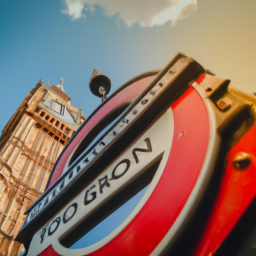

In [83]:
image = artist("london")
display(image)

In [104]:
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
      model="gpt-4o-mini-tts",
      voice="onyx",
      input=message
    )
    display(Audio(response.content, autoplay=True))


In [105]:
talker("Today is a great day!")

### Marco de Trabajo para Agentes (IA)

El término "IA Agentic" y la "agenización" es un término general que se refiere a una serie de técnicas, como:

1. Dividir un problema complejo en pasos más pequeños, con múltiples LLM que realizan tareas especializadas.

2. La capacidad de los LLM de usar herramientas para darles capacidades adicionales.

3. El "entorno del agente", que permite que los agentes colaboren.

4. Un LLM puede actuar como planificador, dividiendo las tareas más grandes en tareas más pequeñas para los especialistas.

5. El concepto de que un agente tenga autonomía/agencia, más allá de simplemente responder a una indicación, como la memoria.

In [130]:
def talkerAI(message):
    response = openai.audio.speech.create(
        model="tts-1", 
        voice="onyx",
        input=message
    )
    
    filename = "response_audio.mp3"
    with open(filename, "wb") as f:
        f.write(response.content)
    
    return filename

In [119]:
def handle_tool_calls_and_return_cities(message):
    responses = []
    cities = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            cities.append(city)
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses, cities

In [125]:
def chat(history):
    # 1. Preparar mensajes para la API
    messages = [{"role": "system", "content": system_prompt}]
    for h in history:
        messages.append({"role": h["role"], "content": h["content"]})
    
    # 2. Llamada a OpenAI
    response = openai.chat.completions.create(model=gpt_model, messages=messages, tools=tools)
    cities = []
    image = None

    while response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        tool_responses, found_cities = handle_tool_calls_and_return_cities(message)
        cities.extend(found_cities)
        messages.append(message)
        messages.extend(tool_responses)
        response = openai.chat.completions.create(model=gpt_model, messages=messages, tools=tools)

    # 3. Procesar respuesta de texto
    reply = response.choices[0].message.content
    history.append({"role": "assistant", "content": reply})

    # 4. Generar Audio (Asegúrate que talkerAI devuelva el PATH del archivo)
    audio_path = talkerAI(reply) 

    # 5. Generar Imagen
    if cities:
        image = artist(cities[0])
    
    # El orden debe coincidir exactamente con message.submit(... outputs=[chatbot, audio_output, image_output])
    return history, audio_path, image

## The 3 types of Gradio UI

`gr.Interface` is for standard, simple UIs

`gr.ChatInterface` is for standard ChatBot UIs

`gr.Blocks` is for custom UIs where you control the components and the callbacks

In [ ]:
# Python 3.11 on Windows uses an "Event Loop" called Proactor that sometimes conflicts with Gradio sockets.
import asyncio
import sys
if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
#---------------------------------------------

# Callbacks (along with the chat() function above)
def put_message_in_chatbot(message, history):
        return "", history + [{"role":"user", "content":message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=250)
        image_output = gr.Image(height=250, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(label="Voice Response", autoplay=True, type="filepath")
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI Assistant:")

# Hooking up events to callbacks

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, audio_output, image_output]
    )

ui.launch(auth=("ed", "bananas"))  #inbrowser=True, 

📦 Platform Update: New Tools, Agents, and Infrastructure Improvements

## ✨ New Features

### 1. More Tools/Agents

- **get_weather():** Retrieves weather information for cities  
- **get_attractions():** Gets tourist attractions  
- Keeps the original **get_ticket_price()**

---

### 2. Reservation Tool

- **make_reservation():** Creates reservations with a unique ID, passenger name, destination, and date  
- Stores all reservations in memory  

---

### 3. Translation Agent

- **translate_text():** Uses Claude to translate responses  
- A right-side panel displays automatic translation  
- Language selector (English, French, Japanese, German, Portuguese)

---

### 4. Audio Input

- Field for recording/uploading audio  
- **transcribe_audio_file()** function prepared (Whisper API integration needed)  
- Displays processed transcription  

---

### 5. Anthropic Claude Model

- Uses **claude-sonnet-4-20250514**  
- Implements Anthropic’s **tools system**  
- Full tool_use cycle handling

## 🎤 Enhanced Audio Functionality

### Automatic Transcription
- When you record or upload audio, it is transcribed automatically.
- The transcription is sent directly to the chat as a user message.
- Works for both: **recording finished** and **file upload** events.

---

## 🔧 Applied Fixes

### 1. Asyncio Handling on Windows
- Improved event loop configuration  
- Suppression of annoying warnings  

### 2. Timeouts and Error Handling
- ✅ 30s timeout for translations  
- ✅ 60s timeout for main chat  
- ✅ Prevention of infinite loops (max 10 iterations)  
- ✅ Specific handling of connection and timeout errors  

### 3. Optimizations
- ✅ Translation is skipped when the language is Spanish  
- ✅ Friendlier error messages with emojis  
- ✅ Server explicitly configured to run on localhost  

### 4. Interface Changes
- Spanish is now the default language  
- If Spanish is selected, no unnecessary translation is performed  

---

## 🎯 Why the `ConnectionResetError` Should Be Gone
- Proper timeouts were added  
- Connection exceptions are handled correctly  
- More stable event loop configuration on Windows  
- Avoidance of unnecessary API calls  


In [ ]:
!pip install anthropic gradio pillow

In [ ]:
import gradio as gr
import json
import anthropic
import openai
import asyncio
import sys
import os
import tempfile
from datetime import datetime
import warnings
import logging

# ============================================================================
# CONFIGURACIÓN INICIAL
# ============================================================================

# Suprimir errores de asyncio en Windows
logging.getLogger('asyncio').setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
    try:
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
    except:
        pass

# Clientes de API
anthropic_client = anthropic.Anthropic()  # Requiere ANTHROPIC_API_KEY
openai_client = openai.OpenAI()  # Requiere OPENAI_API_KEY

# Modelos
CLAUDE_MODEL = "claude-sonnet-4-20250514"

# Datos de la aplicación
ticket_prices = {
    "london": "$799", 
    "paris": "$899", 
    "tokyo": "$1400", 
    "berlin": "$499"
}
reservations = {}

# ============================================================================
# HERRAMIENTAS
# ============================================================================

def get_ticket_price(destination_city):
    """Obtiene el precio de un boleto a una ciudad"""
    print(f"🎫 Tool: get_ticket_price({destination_city})")
    price = ticket_prices.get(destination_city.lower(), "Unknown")
    return f"El precio de un boleto a {destination_city} es {price}"

def get_weather(city):
    """Obtiene el clima de una ciudad (simulado)"""
    print(f"🌤️ Tool: get_weather({city})")
    weather_data = {
        "london": "Nublado, 15°C",
        "paris": "Soleado, 18°C", 
        "tokyo": "Lluvioso, 20°C",
        "berlin": "Ventoso, 12°C"
    }
    return f"El clima en {city} es: {weather_data.get(city.lower(), 'No disponible')}"

def get_attractions(city):
    """Obtiene atracciones turísticas de una ciudad"""
    print(f"🏛️ Tool: get_attractions({city})")
    attractions = {
        "london": "Big Ben, Tower Bridge, Museo Británico",
        "paris": "Torre Eiffel, Louvre, Arco de Triunfo",
        "tokyo": "Torre de Tokyo, Templo Senso-ji, Monte Fuji",
        "berlin": "Puerta de Brandemburgo, Muro de Berlín, Isla de los Museos"
    }
    return f"Atracciones en {city}: {attractions.get(city.lower(), 'No disponible')}"

def make_reservation(destination_city, passenger_name, travel_date):
    """Crea una reserva de viaje"""
    print(f"📝 Tool: make_reservation({passenger_name}, {destination_city}, {travel_date})")
    reservation_id = f"RES{len(reservations) + 1:04d}"
    reservations[reservation_id] = {
        "city": destination_city,
        "passenger": passenger_name,
        "date": travel_date,
        "created_at": datetime.now().isoformat()
    }
    price = ticket_prices.get(destination_city.lower(), "Unknown")
    return f"Reserva confirmada! ID: {reservation_id}, Pasajero: {passenger_name}, Destino: {destination_city}, Fecha: {travel_date}, Precio: {price}"

# Mapeo de funciones
function_map = {
    "get_ticket_price": get_ticket_price,
    "get_weather": get_weather,
    "get_attractions": get_attractions,
    "make_reservation": make_reservation
}

# Definición de tools para Anthropic Claude
tools = [
    {
        "name": "get_ticket_price",
        "description": "Obtiene el precio de un boleto de avión a una ciudad específica",
        "input_schema": {
            "type": "object",
            "properties": {
                "destination_city": {
                    "type": "string",
                    "description": "La ciudad de destino (london, paris, tokyo, berlin)"
                }
            },
            "required": ["destination_city"]
        }
    },
    {
        "name": "get_weather",
        "description": "Obtiene información del clima actual en una ciudad",
        "input_schema": {
            "type": "object",
            "properties": {
                "city": {
                    "type": "string",
                    "description": "La ciudad para consultar el clima"
                }
            },
            "required": ["city"]
        }
    },
    {
        "name": "get_attractions",
        "description": "Obtiene las principales atracciones turísticas de una ciudad",
        "input_schema": {
            "type": "object",
            "properties": {
                "city": {
                    "type": "string",
                    "description": "La ciudad para consultar atracciones"
                }
            },
            "required": ["city"]
        }
    },
    {
        "name": "make_reservation",
        "description": "Crea una reserva de viaje para un pasajero",
        "input_schema": {
            "type": "object",
            "properties": {
                "destination_city": {
                    "type": "string",
                    "description": "Ciudad de destino"
                },
                "passenger_name": {
                    "type": "string",
                    "description": "Nombre del pasajero"
                },
                "travel_date": {
                    "type": "string",
                    "description": "Fecha de viaje (formato: YYYY-MM-DD)"
                }
            },
            "required": ["destination_city", "passenger_name", "travel_date"]
        }
    }
]

# ============================================================================
# FUNCIONES AUXILIARES
# ============================================================================

def translate_text(text, target_language):
    """Traduce texto a otro idioma usando Claude"""
    if target_language.lower() == "español" or not text.strip():
        return text
    
    print(f"🌐 Traduciendo a {target_language}...")
    
    translation_prompt = f"""Traduce el siguiente texto al {target_language}. 
Solo devuelve la traducción, sin explicaciones adicionales.

Texto a traducir:
{text}"""
    
    try:
        response = anthropic_client.messages.create(
            model=CLAUDE_MODEL,
            max_tokens=1024,
            messages=[{"role": "user", "content": translation_prompt}],
            timeout=30.0
        )
        return response.content[0].text
    except anthropic.APITimeoutError:
        return f"[Tiempo de espera agotado]\n\n{text}"
    except anthropic.APIConnectionError:
        return f"[Error de conexión]\n\n{text}"
    except Exception as e:
        print(f"❌ Error en traducción: {str(e)}")
        return f"[Error]\n\n{text}"

def text_to_speech(text):
    """Convierte texto a voz usando OpenAI TTS"""
    if not text or len(text.strip()) == 0:
        return None
        
    print(f"🎤 Generando audio...")
    
    try:
        # Truncar texto si es muy largo
        max_length = 4096
        if len(text) > max_length:
            text = text[:max_length] + "..."
        
        response = openai_client.audio.speech.create(
            model="tts-1",
            voice="nova",
            input=text,
            response_format="mp3"
        )
        
        # Crear archivo temporal
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.mp3', mode='wb')
        temp_path = temp_file.name
        
        # Escribir audio
        response.write_to_file(temp_path)
        temp_file.close()
        
        # Verificar archivo
        if os.path.exists(temp_path) and os.path.getsize(temp_path) > 0:
            print(f"✅ Audio generado: {temp_path}")
            return temp_path
        else:
            print("❌ Archivo de audio vacío")
            return None
        
    except Exception as e:
        print(f"❌ Error generando audio: {str(e)}")
        return None

def transcribe_audio(audio_path):
    """Transcribe audio usando OpenAI Whisper"""
    if audio_path is None:
        return None, None
    
    print(f"🎧 Transcribiendo audio...")
    
    try:
        with open(audio_path, "rb") as audio_file:
            transcript = openai_client.audio.transcriptions.create(
                model="whisper-1",
                file=audio_file,
                language="es"
            )
        print(f"✅ Transcripción: {transcript.text}")
        return transcript.text, transcript.text
    except Exception as e:
        error_msg = f"Error al transcribir: {str(e)}"
        print(f"❌ {error_msg}")
        return error_msg, None

# ============================================================================
# LÓGICA PRINCIPAL DEL CHAT
# ============================================================================

system_prompt = """Eres un asistente de viajes inteligente y amigable. Puedes:
1. Consultar precios de boletos de avión
2. Verificar el clima en diferentes ciudades
3. Recomendar atracciones turísticas
4. Crear reservas de viaje

Ciudades disponibles: London, Paris, Tokyo, Berlin

Cuando el usuario pregunte por información, usa las herramientas disponibles.
Para hacer una reserva, necesitas el nombre del pasajero, ciudad de destino y fecha de viaje.
Sé amigable y profesional en tus respuestas."""

def chat_logic(history, target_language="español"):
    """Procesa el chat usando Claude con herramientas"""
    
    # Preparar mensajes
    messages = []
    for h in history:
        if h["role"] in ["user", "assistant"]:
            messages.append({"role": h["role"], "content": h["content"]})
    
    try:
        # Primera llamada a Claude
        response = anthropic_client.messages.create(
            model=CLAUDE_MODEL,
            max_tokens=2048,
            system=system_prompt,
            tools=tools,
            messages=messages,
            timeout=60.0
        )
        
        # Procesar tool calls (máximo 10 iteraciones)
        iteration_count = 0
        max_iterations = 10
        
        while response.stop_reason == "tool_use" and iteration_count < max_iterations:
            iteration_count += 1
            
            assistant_content = []
            tool_results = []
            
            # Procesar cada bloque de contenido
            for content_block in response.content:
                if content_block.type == "text":
                    assistant_content.append(content_block)
                elif content_block.type == "tool_use":
                    assistant_content.append(content_block)
                    
                    # Ejecutar la herramienta
                    tool_name = content_block.name
                    tool_input = content_block.input
                    
                    try:
                        if tool_name in function_map:
                            result = function_map[tool_name](**tool_input)
                        else:
                            result = f"Herramienta {tool_name} no encontrada"
                    except Exception as e:
                        result = f"Error ejecutando {tool_name}: {str(e)}"
                    
                    tool_results.append({
                        "type": "tool_result",
                        "tool_use_id": content_block.id,
                        "content": result
                    })
            
            # Agregar al historial
            messages.append({"role": "assistant", "content": assistant_content})
            messages.append({"role": "user", "content": tool_results})
            
            # Siguiente llamada a Claude
            response = anthropic_client.messages.create(
                model=CLAUDE_MODEL,
                max_tokens=2048,
                system=system_prompt,
                tools=tools,
                messages=messages,
                timeout=60.0
            )
        
        # Extraer respuesta final
        reply = ""
        for content_block in response.content:
            if content_block.type == "text":
                reply += content_block.text
        
        # Agregar al historial
        history.append({"role": "assistant", "content": reply})
        
        # Generar audio
        audio_path = text_to_speech(reply)
        
        # Traducir (si no es español)
        translated = translate_text(reply, target_language) if target_language.lower() != "español" else reply
        
        return history, reply, audio_path, translated
        
    except anthropic.APITimeoutError:
        error_msg = "⏱️ Tiempo de espera agotado. Intenta de nuevo."
        history.append({"role": "assistant", "content": error_msg})
        return history, error_msg, None, error_msg
    except anthropic.APIConnectionError:
        error_msg = "🔌 Error de conexión. Verifica tu internet."
        history.append({"role": "assistant", "content": error_msg})
        return history, error_msg, None, error_msg
    except Exception as e:
        error_msg = f"❌ Error: {str(e)}"
        history.append({"role": "assistant", "content": error_msg})
        return history, error_msg, None, error_msg

# ============================================================================
# CALLBACKS DE GRADIO
# ============================================================================

def add_message_to_chat(message, history):
    """Agrega mensaje del usuario al chatbot"""
    return "", history + [{"role": "user", "content": message}]

def process_audio_input(audio, history, language):
    """Transcribe audio y lo envía al chat"""
    if audio is None:
        return history, "", None, "", "No se recibió audio"
    
    # Transcribir
    transcription, text_to_send = transcribe_audio(audio)
    
    if text_to_send is None:
        return history, "", None, "", transcription
    
    # Agregar al historial
    history = history + [{"role": "user", "content": text_to_send}]
    
    # Procesar con chat
    updated_history, original, audio_output, translated = chat_logic(history, language)
    
    return updated_history, original, audio_output, translated, transcription

# ============================================================================
# INTERFAZ DE GRADIO
# ============================================================================

with gr.Blocks(title="Asistente de Viajes Multiagente", theme=gr.themes.Soft()) as ui:
    
    gr.Markdown("# 🌍 Asistente de Viajes con IA Multiagente")
    gr.Markdown("**Powered by Claude Sonnet 4 & OpenAI** | Pregunta por precios, clima, atracciones o haz reservas")
    
    # Botón de inicio para habilitar autoplay
    start_btn = gr.Button("▶️ Iniciar Asistente (Habilita Audio Automático)", variant="primary", size="sm")
    start_btn.click(lambda: gr.Info("✅ Audio habilitado! Ya puedes usar el asistente."), outputs=[])
    
    with gr.Row():
        # Columna 1: Chat principal
        with gr.Column(scale=2):
            chatbot = gr.Chatbot(height=400, label="💬 Conversación")
            
            with gr.Row():
                message = gr.Textbox(
                    label="Escribe tu mensaje:", 
                    placeholder="Ej: ¿Cuánto cuesta un boleto a París?",
                    scale=4
                )
                language = gr.Dropdown(
                    choices=["español", "inglés", "francés", "japonés", "alemán", "portugués"],
                    value="español",
                    label="Traducir a:",
                    scale=1
                )
        
        # Columna 2: Traducción
        with gr.Column(scale=1):
            translated_output = gr.Textbox(
                label="🌐 Traducción Automática", 
                lines=20, 
                interactive=False
            )
    
    with gr.Row():
        # Respuesta original
        original_output = gr.Textbox(label="📝 Respuesta Original", lines=3, interactive=False)
        # Audio output
        audio_output = gr.Audio(label="🔊 Respuesta de Voz", type="filepath", autoplay=True)
    
    with gr.Row():
        audio_input = gr.Audio(
            label="🎤 Grabar o Subir Audio",
            sources=["microphone", "upload"],
            type="filepath"
        )
        transcription = gr.Textbox(
            label="📝 Transcripción", 
            interactive=False,
            placeholder="La transcripción aparecerá aquí"
        )
    
    gr.Markdown("""
    ### 💡 Instrucciones:
    - **Texto**: Escribe y presiona Enter para conversar
    - **Voz**: Graba o sube audio para que se transcriba automáticamente
    - **Traducción**: Selecciona un idioma para ver la respuesta traducida
    
    ### 📌 Ejemplos:
    - ¿Cuánto cuesta volar a Tokyo?
    - ¿Cómo está el clima en Londres?
    - ¿Qué atracciones hay en Berlín?
    - Quiero reservar un vuelo a París para María López el 2025-03-20
    """)
    
    # JavaScript para autoplay
    ui.load(js="""
    function() {
        const audio = document.querySelector('audio');
        if (audio) {
            audio.setAttribute('autoplay', 'true');
            audio.play().catch(e => console.log('Autoplay bloqueado:', e));
        }
        return [];
    }
    """)
    
    # Eventos
    message.submit(
        add_message_to_chat, 
        inputs=[message, chatbot], 
        outputs=[message, chatbot]
    ).then(
        chat_logic, 
        inputs=[chatbot, language], 
        outputs=[chatbot, original_output, audio_output, translated_output]
    )
    
    audio_input.stop_recording(
        process_audio_input,
        inputs=[audio_input, chatbot, language],
        outputs=[chatbot, original_output, audio_output, translated_output, transcription]
    )
    
    audio_input.upload(
        process_audio_input,
        inputs=[audio_input, chatbot, language],
        outputs=[chatbot, original_output, audio_output, translated_output, transcription]
    )

# ============================================================================
# LANZAMIENTO
# ============================================================================

if __name__ == "__main__":
    print("="*60)
    print("🚀 ASISTENTE DE VIAJES MULTIAGENTE")
    print("="*60)
    print("📍 URL: http://127.0.0.1:7860")
    print("👤 Usuario: ed | Contraseña: bananas")
    print("="*60)
    
    try:
        ui.launch(
            auth=("ed", "bananas"), 
            share=False,
            server_name="127.0.0.1",
            server_port=7860,
            show_error=True,
            quiet=False,
            favicon_path=None,
            ssl_verify=False
        )
    except KeyboardInterrupt:
        print("\n👋 Aplicación detenida")
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Intentando configuración alternativa...")
        try:
            ui.launch(auth=("ed", "bananas"), share=False)
        except Exception as e2:
            print(f"❌ Error fatal: {e2}")

C:\Users\User\AppData\Local\Temp\ipykernel_17384\499930428.py:407: UserWarning: The parameters have been moved from the Blocks constructor to the launch() method in Gradio 6.0: theme. Please pass these parameters to launch() instead.
  with gr.Blocks(title="Asistente de Viajes Multiagente", theme=gr.themes.Soft()) as ui:


🚀 ASISTENTE DE VIAJES MULTIAGENTE
📍 URL: http://127.0.0.1:7860
👤 Usuario: ed | Contraseña: bananas
❌ Error: Cannot find empty port in range: 7860-7860. You can specify a different port by setting the GRADIO_SERVER_PORT environment variable or passing the `server_port` parameter to `launch()`.
Intentando configuración alternativa...
* Running on local URL:  http://127.0.0.1:7873
* To create a public link, set `share=True` in `launch()`.


🎤 Generando audio...
✅ Audio generado: C:\Users\User\AppData\Local\Temp\tmp_ceo8nzd.mp3
🎤 Generando audio...
✅ Audio generado: C:\Users\User\AppData\Local\Temp\tmpvxn0e09p.mp3
🌐 Traduciendo a inglés...
🎧 Transcribiendo audio...
✅ Transcripción: Quiero viajar a Londres.
🎤 Generando audio...
✅ Audio generado: C:\Users\User\AppData\Local\Temp\tmpl46i8mqc.mp3
🌐 Traduciendo a inglés...
